In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy
import skimage
sys.path.append("../src")
import exlib
from exlib.datasets.chestx import ChestXDataset, ChestXPathologyModel, ChestXMetric

## Overview
* The objective is to predict the **pathology** regions (atelectasis, calcification, etc. Total 13).
* The higher-level features are the anatomical **structures** (left clavicle, right clavicle, etc. Total 14).

In [2]:
dataset = ChestXDataset(split="test")
pathols_model = ChestXPathologyModel().from_pretrained("BrachioLab/chestx_pathols").eval()

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

## Dataset samples and model predictions
Primary task: predict where the pathologies are

In [3]:
torch.manual_seed(105)
for i in torch.randperm(len(dataset)):
    sample = dataset[i.item()]
    image, pathols, structs = sample["image"], sample["pathols"], sample["structs"]
    if pathols.sum() > 0 and structs.sum() > 0:
        break

with torch.no_grad():
    pathols_pred = pathols_model(image[None,...])[0]

Atelectasis: 0.140
Cardiomegaly: 0.052
Consolidation: 0.358
Edema: 0.015
Effusion: 0.049
Emphysema: 0.500
Fibrosis: 0.504
Hernia: 0.260
Infiltration: 0.520
Mass: 0.059
Nodule: 0.509
Pleural_Thickening: 0.509
Pneumonia: 0.067
Pneumothorax: 0.044


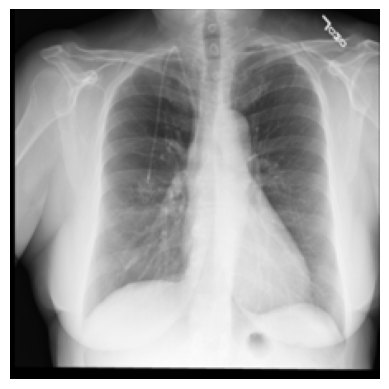

In [4]:
plt.clf()
plt.imshow(image.numpy().transpose(1,2,0), cmap="gray")
plt.axis("off")

for name, score in zip(dataset.pathology_names, pathols_pred):
    print(f"{name}: {score:.3f}")

## Expert-specified higher-level features: anatomical structures
Identifying where key structures are is important!

<Figure size 640x480 with 0 Axes>

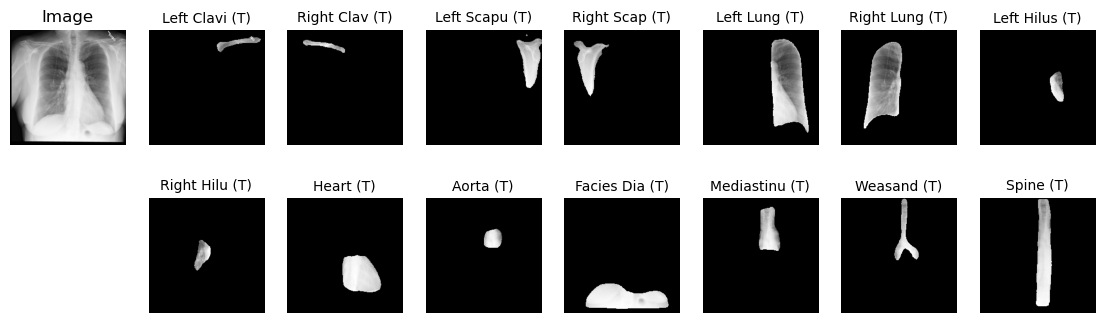

In [5]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    (["image"] + [f"struct{i}t" for i in range(7)]),
    (["."] + [f"struct{i}t" for i in range(7,14)]),
], figsize=(14,4))

for _, a in ax.items(): a.set_axis_off()
struct_titles = ChestXDataset.structure_names

ax["image"].imshow(image.numpy().transpose(1,2,0), cmap="gray")
ax["image"].set_title("Image")

for i in range(14):
    mask_t = structs[i].unsqueeze(0)
    ax[f"struct{i}t"].imshow(((image * mask_t).numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"struct{i}t"].set_title(f"{struct_titles[i][:10]} (T)", fontsize=10)

## How well are the higher-level feature alignments?
Let's define two different high-level feature extractors for comparison:
* gridding
* quickshift

In [6]:
class GridGroups(nn.Module):
    # Let's assume image is 224x224 and make 28-wide grids (i.e., 8x8 partitions)
    def __init__(self):
        super().__init__()

    def forward(self, x):
        N, _, _, _ = x.shape
        mask_small = torch.tensor(range(8*8)).view(1,1,8,8).repeat(N,1,1,1)
        mask_big = F.interpolate(mask_small.float(), scale_factor=28).round().long()
        return mask_big.view(N,224,224)

In [7]:
class QuickShiftGroups(nn.Module):
    # Use quickshift to perform image segmentation
    def __init__(self, kernel_size=10, max_dist=20, sigma=5, max_segs=40):
        super().__init__()
        self.kernel_size = kernel_size
        self.max_dist = max_dist
        self.sigma = sigma
        self.max_segs = max_segs

    def quickshift(self, image):
        # image is (C,H,W)
        C, _, _ = image.shape
        if C == 1:
            image = image.repeat(3,1,1)
        image_np = image.numpy().transpose(1,2,0)
        segs = skimage.segmentation.quickshift(image_np, kernel_size=self.kernel_size, max_dist=self.max_dist, sigma=self.sigma)
        segs = torch.tensor(segs)
        segs[segs >= self.max_segs] = self.max_segs - 1
        return segs.long() # (H,W) of integers

    def forward(self, x):
        # x: (N,C,H,W)
        segs = torch.stack([self.quickshift(xi.cpu()) for xi in x]) # (N,H,W)
        return segs.to(x.device)

In [8]:
import numpy as np
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

class WatershedGroups(nn.Module):
    def __init__(self, fp_size=10, min_dist=20, compactness=10, max_segs=64):
        """
        compactness: Higher values result in more regularly-shaped watershed basins.
        """
        super().__init__()
        self.fp_size = fp_size
        self.min_dist = min_dist
        self.compactness = compactness
        self.max_segs = max_segs

    def watershed(self, image):
        # image is (C,H,W)
        image = (image.mean(dim=0).numpy() * 255).astype(np.uint8)
        distance = ndi.distance_transform_edt(image)
        coords = peak_local_max(
            distance,
            min_distance=self.min_dist,
            footprint=np.ones((self.fp_size,self.fp_size)),
            labels=image,
        )
        # coords = peak_local_max(distance, min_distance=10, labels=image)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndi.label(mask)
        segs = skimage.segmentation.watershed(
            -distance,
            markers,
            mask=image,
            compactness = self.compactness
        )
        # segs = skimage.segmentation.watershed(image_np, kernel_size=self.kernel_size, max_dist=self.max_dist, sigma=self.sigma)
        segs = torch.tensor(segs)
        div_by = (segs.unique().max() / self.max_segs).long().item() + 1
        segs = segs // div_by
        return segs.long() # (H,W) of integers

    def forward(self, x):
        # x: (N,C,H,W)
        segs = torch.stack([self.watershed(xi.cpu()) for xi in x]) # (N,H,W)
        return segs.to(x.device)

In [9]:
metric = ChestXMetric()
grid_groups = GridGroups()
qshift_groups = QuickShiftGroups()
watershed_groups = WatershedGroups()
torch.manual_seed(1234)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
grid_scores, qshift_scores, watershed_scores = [], [], []
for i, item in enumerate(tqdm(dataloader)):
    image = item["image"]
    with torch.no_grad():
        structs_masks = item["structs"]
        grid_masks = F.one_hot(grid_groups(image)).permute(0,3,1,2)
        qshift_masks = F.one_hot(qshift_groups(image)).permute(0,3,1,2)
        watershed_masks = F.one_hot(watershed_groups(image)).permute(0,3,1,2)
        
        grid_score = metric(grid_masks, structs_masks) # (N,H,W)
        qshift_score = metric(qshift_masks, structs_masks)
        watershed_score = metric(watershed_masks, structs_masks)
        grid_scores.append(grid_score.mean(dim=(1,2)))
        qshift_scores.append(qshift_score.mean(dim=(1,2)))
        watershed_scores.append(watershed_score.mean(dim=(1,2)))
    if i > 10:
        break

grid_scores = torch.cat(grid_scores)
qshift_scores = torch.cat(qshift_scores)
watershed_scores = torch.cat(watershed_scores)

print(f"Avg alignment of grid groups: {grid_scores.mean():.4f}")
print(f"Avg alignment of qshift groups: {qshift_scores.mean():.4f}")
print(f"Avg alignment of watershed groups: {watershed_scores.mean():.4f}")

  1%|          | 11/1444 [01:57<4:15:49, 10.71s/it]

Avg alignment of grid groups: 0.0997
Avg alignment of qshift groups: 0.3514
Avg alignment of watershed groups: 0.0717
